In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_decision_regions

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import os

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, roc_results, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/py36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
stocks = ['9061', '9064', '9265']
rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]
K = 50

dfs = pd.DataFrame()
dfs_cv = pd.DataFrame()
dfs_test = pd.DataFrame()
for stock in stocks:
    for r in rr:
        for s in ss:
            filename = 'data_gdf_feature_scaling/gdf_{}_r{}_s{}_K{}_feature_scaling.csv'.format(
                stock, r, s, K)
            df = pd.read_csv(filename)
            df_queue = pd.read_csv('data/{}.csv'.format(stock))
            df['r'] = np.zeros(len(df)) + r
            df['s'] = np.zeros(len(df)) + s
            df['stock'] = [stock] * len(df)
            df['queue_imbalance'] = df_queue['queue_imbalance']
            dfs = dfs.append(df.iloc[2000:10000])
            dfs_test = dfs_test.append(df.iloc[0:2000])

In [3]:
gdf_columns = [c for c in dfs.columns if 'gdf' in c]
dfs.head()

,Unnamed: 0,datetime,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,...,gdf_6,gdf_7,gdf_8,gdf_9,mid_price,mid_price_indicator,queue_imbalance,r,s,stock
2000,2000,2013-09-10 09:41:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,708.70,0.0,0.562770,0.01,0.01,9061
2001,2001,2013-09-10 09:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,707.65,0.0,-0.508517,0.01,0.01,9061
2002,2002,2013-09-10 09:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,707.45,0.0,0.684843,0.01,0.01,9061
2003,2003,2013-09-10 09:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,707.20,1.0,0.214467,0.01,0.01,9061
2004,2004,2013-09-10 09:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,707.40,0.0,0.351926,0.01,0.01,9061


In [4]:
def get_gdf_with_data(df):
    columns_with_data = []
    for c in gdf_columns:
        if np.any(df[df[c] > 0.0]):
            columns_with_data.append(c)
    return columns_with_data

In [21]:
def get_10_fold_validation_results_for_logistic_regression(dfs, rr, ss, stocks, feature_columns):
    train_results = []
    for stock in stocks:
        for r in rr:
            for s in ss:
                for k, feature_column in feature_columns.items():
                    df_stock = dfs[dfs['stock'] == stock]
                    df_r = df_stock[df_stock['r'] == r]
                    df = df_r[df_r['s'] == s]

                    clf = LogisticRegression()
                    res = model.validate_model(clf, df[feature_column], df['mid_price_indicator'], folds=10)
                    res = {**res, 'r': r, 's': s,'stock': stock, 'features': k}
                    train_results.append(res)
    return train_results

feature_columns = {
    'gdf_all': gdf_columns, 
    'que+gdf_all': ['queue_imbalance'] + gdf_columns, 
    'gdf_19-29': ['gdf_{}'.format(c) for c in range(19, 30)],
    'que+gdf_19-29': ['queue_imbalance'] + ['gdf_{}'.format(c) for c in range(19, 30)],
    'gdf_23-27': ['gdf_23', 'gdf_24', 'gdf_25', 'gdf_26'],
    'que+gdf_23-27': ['queue_imbalance', 'gdf_23', 'gdf_24', 'gdf_25', 'gdf_26'],
    'gdf_24-25': ['gdf_24', 'gdf_25'], 
    'que+gdf_24-25': ['queue_imbalance', 'gdf_24', 'gdf_25'], 
    'que': ['queue_imbalance']
}

if os.path.exists('logisitc_results_scaled_features.csv'):
    df_log_res = pd.read_csv('logisitc_results_scaled_features.csv')
else:
    df_log_res = pd.DataFrame(
        get_10_fold_validation_results_for_logistic_regression(dfs, rr, ss, stocks, feature_columns))
    df_log_res.to_csv('logisitc_results_scaled_features.csv')

In [22]:
df_log_res.sort_values(by=['f1'], ascending=False).groupby('stock').head(5)

,f1,features,precision,r,recall,roc_auc,s,stock,train_f1,train_precision,train_recall,train_roc_auc
258,0.673942,gdf_24-25,0.508416,0.01,0.999707,0.500173,0.50,9064,0.671371,0.508210,0.989479,0.500681
402,0.673937,gdf_24-25,0.508330,0.50,1.000000,0.500000,1.00,9064,0.673587,0.507831,1.000000,0.500000
443,0.673937,gdf_19-29,0.508330,1.00,1.000000,0.500000,1.00,9064,0.673587,0.507831,1.000000,0.500000
391,0.673937,gdf_23-27,0.508330,0.50,1.000000,0.500000,0.50,9064,0.673587,0.507831,1.000000,0.500000
267,0.673937,gdf_24-25,0.508330,0.01,1.000000,0.500000,1.00,9064,0.672611,0.507731,0.996140,0.499806
460,0.566069,que+gdf_all,0.557902,0.01,0.588445,0.557110,0.05,9265,0.535636,0.558519,0.515216,0.561917
604,0.565899,que+gdf_all,0.557053,0.50,0.588256,0.556191,0.10,9265,0.537431,0.560257,0.517075,0.563478
606,0.564073,que+gdf_19-29,0.556153,0.50,0.585308,0.555087,0.10,9265,0.536359,0.558924,0.516187,0.562374
640,0.563898,que+gdf_all,0.558378,1.00,0.584855,0.556914,0.05,9265,0.535749,0.559013,0.514941,0.562306
608,0.562991,que+gdf_23-27,0.555306,0.50,0.583451,0.554173,0.10,9265,0.536005,0.558240,0.516119,0.561829


In [8]:
%%capture
for stock in stocks:
    for k, feature_column in feature_columns.items():
        plt.figure()
        sns.scatterplot(x='s', y='r', hue='f1', data=df_log_res[df_log_res['features'] == k])
        plt.title('{}_{}'.format(stock, k))
        plt.savefig('plots_scaled_features/{}_{}.png'.format(stock, k))

In [9]:
df_log_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 9 columns):
Unnamed: 0    675 non-null int64
f1            675 non-null float64
features      675 non-null object
precision     675 non-null float64
r             675 non-null float64
recall        675 non-null float64
roc_auc       675 non-null float64
s             675 non-null float64
stock         675 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 47.5+ KB


In [20]:
%%capture
for stock in stocks:
    for k, feature_column in feature_columns.items():
        plt.figure()
        df_pivot = df_log_res[df_log_res['features'] == k][df_log_res['stock'] == int(stock)].pivot(
            'r', 's', 'f1')
        sns.heatmap(df_pivot, annot=True)
        plt.title('{}_{}'.format(stock, k))
        plt.savefig('plots_scaled_features/{}_{}.png'.format(stock, k))

## Ada training

In [11]:
def logistic_regression(df, columns):
    clf = Pipeline([
      ('classification', AdaBoostClassifier())
    ])
    X = df[columns]
    y = df['mid_price_indicator']
    clf.fit(X, y)
    return clf

In [12]:
r = 0.05
s = 0.5
stock = '9061'
df_stock = dfs[dfs['stock'] == stock]
df_r = df_stock[df_stock['r'] == r]
df = df_r[df_r['s'] == s]


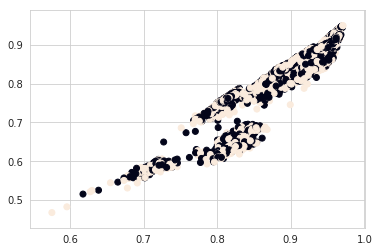

In [23]:
plt.scatter(df['gdf_25'], df['gdf_24'], c=df['mid_price_indicator'])

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import BayesianRidge

gammas = [0.01, 1.0, 100.0, 1000.0, 10000.0]
Cs = [0.01, 1.0, 100.0, 1000.0, 10000.0]
coef0s = [0.01, 1.0, 100.0]
learning_rate = np.linspace(0.0001, 2, num=100)
res = []

feature_columns = ['gdf_22', 'gdf_23', 'gdf_24', 'gdf_25', 'gdf_26', 'gdf_27', 'queue_imbalance']

res_train = []
res_cv = []

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
for l in learning_rate:
    clf = Pipeline([
     # ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False))),
      ('classification', GradientBoostingClassifier(learning_rate=l))
    ])
    
    clf.fit(df[feature_columns], df['mid_price_indicator'])
    pred = clf.predict(df[feature_columns])
    s1 = roc_auc_score(df['mid_price_indicator'], pred)
    f1 = metrics.f1_score(df['mid_price_indicator'], pred)

    pred_cv = clf.predict(df_cv[feature_columns])
    s2 = roc_auc_score(df_cv['mid_price_indicator'], pred_cv)
    f2 = metrics.f1_score(df_cv['mid_price_indicator'], pred_cv)
    res.append({'learning rate': l, 'stock': stock, 'r': r, 's': s,
               'svm_train': s1, 'svm_cv': s2, 'svm_f1_train': f1, 'svm_f1_cv': f2})
    res_train.append(s1)
    res_cv.append(s2)

NameError: name 'df_cv' is not defined

In [ ]:
feature_columns = ['queue_imbalance']

clf = GradientBoostingClassifier(learning_rate=0.23)
clf.fit(df[feature_columns], df['mid_price_indicator'])
plot_decision_regions(df[feature_columns].values, df['mid_price_indicator'].values.astype(np.integer), clf=clf,
                     colors=','.join(['orange', 'blue']))


In [ ]:
plt.plot(learning_rate, res_train, label='train')
plt.plot(learning_rate, res_cv, label='cv')
plt.legend()

In [ ]:
df_res = pd.DataFrame(res)
df_res.sort_values(by=['svm_f1_cv', 'svm_f1_cv'], ascending=False)

In [ ]:
clf = Pipeline([
      ('feature_selection', SelectFromModel(LinearSVC(penalty='l2'))),
      ('classification', AdaBoostClassifier(learning_rate=1.5))
    ])
lob.plot_learning_curve(clf, df[feature_columns], df['mid_price_indicator'], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), title='', ax=None,
                        scoring='roc_auc')

In [ ]:
%%capture
fig = plt.figure(figsize=(64, 64)) 
sns.heatmap(df.corr(), annot=True)
fig.savefig('corr.png')
